In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


In [2]:
import numpy as np
import pandas as pd, gc 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [3]:
#read sample submission 
df_test = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv")
print(len(df_test))
df_test.head(50)
df_test = df_test[df_test["session_id"].str.contains("20090312433251036")]
#df_test.head()

54


In [23]:
#read test.csv
df_test = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/test.csv")
print(df_test["session_id"].value_counts())
df_test = df_test[df_test["session_id"] == 20090312331414616]
df_test.tail(50)
df_test['session_level'].value_counts()


20090312143683264    1501
20090109393214576    1262
20090312331414616     965
Name: session_id, dtype: int64


8    517
7    318
6    130
Name: session_level, dtype: int64

# EDA

In [21]:
def make2D(xvar,yvar) :
    df_test.plot(kind='scatter', x=xvar, y=yvar)

    # set the axis labels and plot title
    
    plt.xlabel(xvar)
    plt.ylabel(yvar)
    plt.title('Scatter Plot')

    # show the plot
    return plt

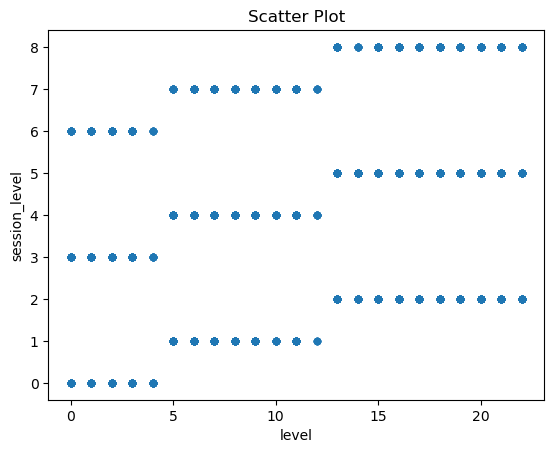

In [61]:
xvar = 'level'
yvar = 'session_level'

plt = make2D(xvar,yvar)
plt.show()

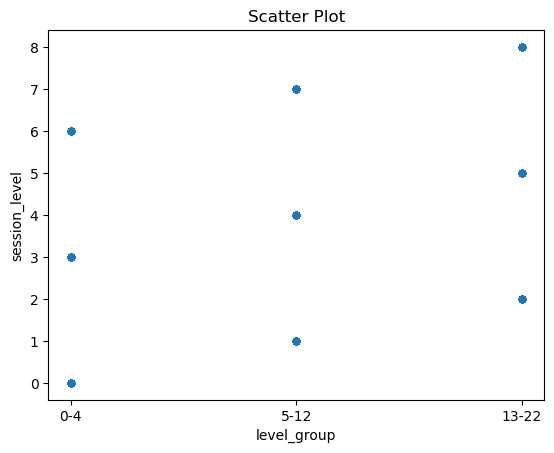

In [62]:
xvar = 'level_group'
yvar = 'session_level'

plt = make2D(xvar,yvar)
plt.show()

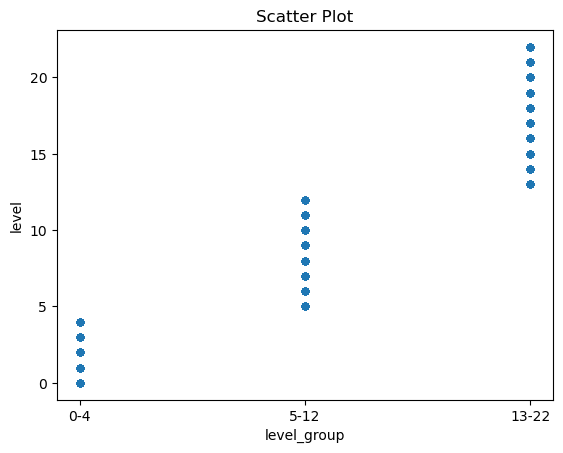

In [63]:
xvar = 'level_group'
yvar = 'level'

plt = make2D(xvar,yvar)
plt.show()

In [4]:
df= pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv",usecols=[0])
len(df)
df

,session_id
0,20090312431273200
1,20090312431273200
2,20090312431273200
3,20090312431273200
4,20090312431273200
...,...
26296941,22100221145014656
26296942,22100221145014656
26296943,22100221145014656
26296944,22100221145014656


In [5]:
df = df.groupby('session_id').session_id.agg('count')

# COMPUTE READS AND SKIPS
PIECES = 10
CHUNK = int( np.ceil(len(df)/PIECES) )
print(CHUNK)

reads = []
skips = [0]
for k in range(PIECES):
    a = k*CHUNK
    b = (k+1)*CHUNK
    if b>len(df): b=len(df)
    r = df.iloc[a:b].sum()
    reads.append(r)
    skips.append(skips[-1]+r)
    
print(f'To avoid memory error, we will read the dataset in {PIECES} pieces of sizes:')
print(reads)

2357
To avoid memory error, we will read the dataset in 10 pieces of sizes:
[2684191, 2631991, 2638304, 2657670, 2644229, 2629801, 2596616, 2602258, 2619995, 2591891]


In [6]:
train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', nrows=reads[0])
print('Train size of first piece:', train.shape )

#train = train[train["session_id"] ==20090312431273200]
#train.head(60)

Train size of first piece: (2684191, 20)


In [7]:
train.head(10)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
5,20090312431273200,5,3423,person_click,basic,0,NaN,-412.991405,-157.314686,381.0,492.0,NaN,"Sure thing, Jo. Grab your notebook and come up...",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
6,20090312431273200,6,5197,person_click,basic,0,NaN,478.485079,-199.971679,593.0,485.0,NaN,"See you later, Teddy.",teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
7,20090312431273200,7,6180,person_click,basic,0,NaN,503.355128,-168.619913,609.0,453.0,NaN,I get to go to Gramps's meeting!,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
8,20090312431273200,8,7014,person_click,basic,0,NaN,510.733442,-157.720642,615.0,442.0,NaN,Now where did I put my notebook?,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
9,20090312431273200,9,7946,person_click,basic,0,NaN,512.048005,-153.743631,616.0,438.0,NaN,\u00f0\u0178\u02dc\u00b4,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4


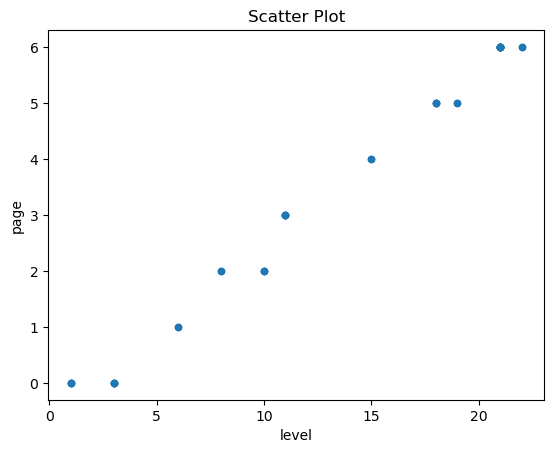

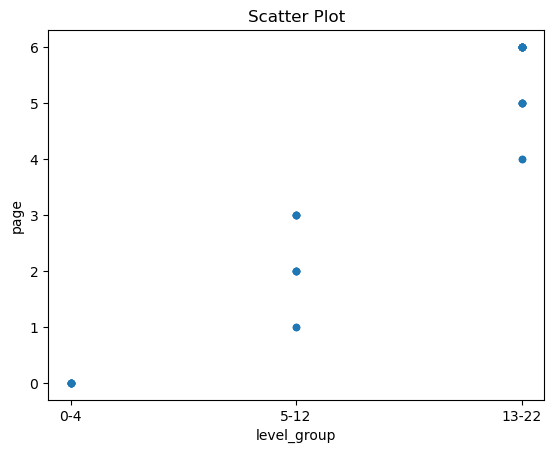

In [27]:
yvar = 'page'

plt = make2D('level',yvar)
plt.show()

plt = make2D('level_group',yvar)
plt.show()

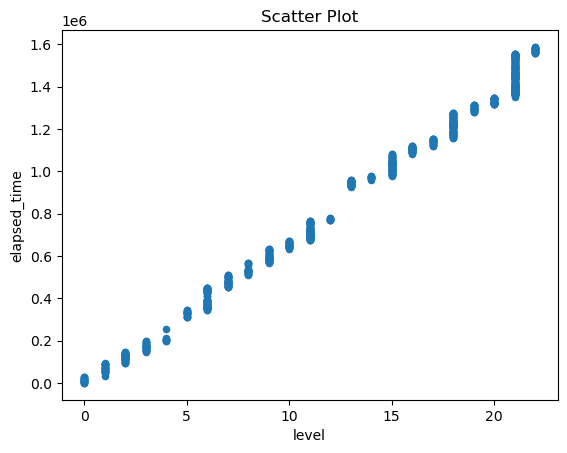

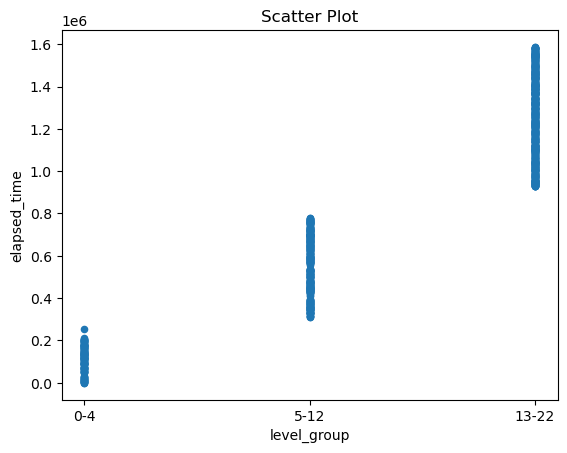

In [26]:
yvar = 'elapsed_time'

plt = make2D('level',yvar)
plt.show()


plt = make2D('level_group',yvar)
plt.show()

In [59]:
train['lag'] = train.elapsed_time.diff(1)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,lag
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,...,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,NaN
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,...,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,1323.0
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,...,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,-492.0
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,...,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,316.0
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,...,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,716.0


<AxesSubplot:>

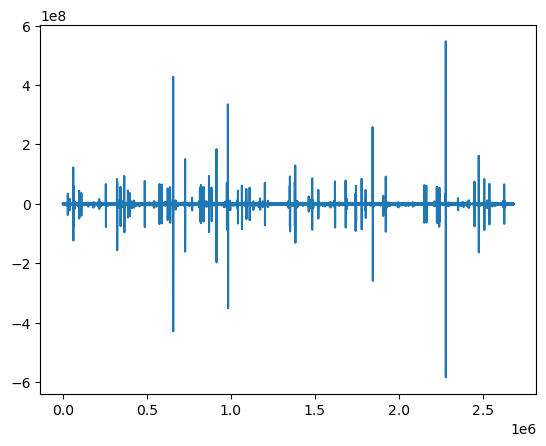

In [68]:
train.lag.dropna().plot()

<AxesSubplot:xlabel='lag', ylabel='level'>

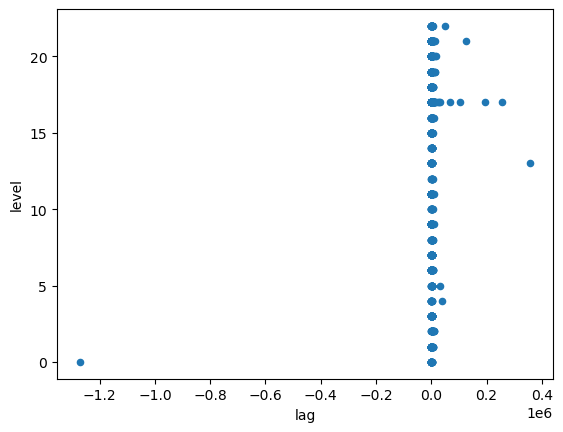

In [66]:
df_test_1 = train[train["session_id"]==20090312433251036]
df_test_1.dropna()
df_test_1.plot(kind='scatter', y='level', x='lag')


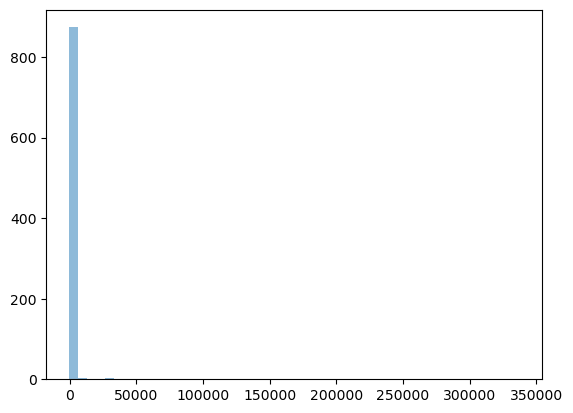

In [53]:
df_test = train[train["session_id"]==20090312431273200]
#df_test.elapsed_time.hist()
plt.hist(df_test.elapsed_time.diff(1), bins=50, alpha=0.5, label='ET')
plt.show()

<AxesSubplot:>

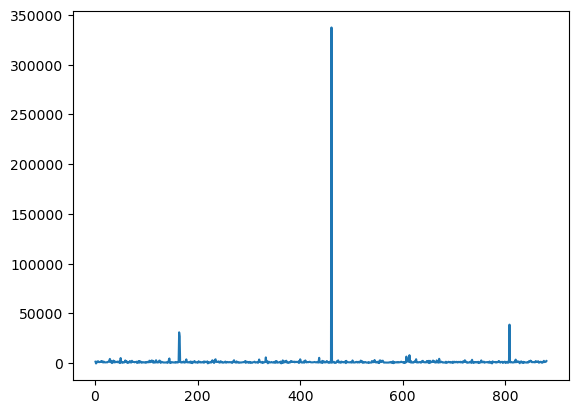

In [56]:

df_test.elapsed_time.diff(1).dropna().plot()

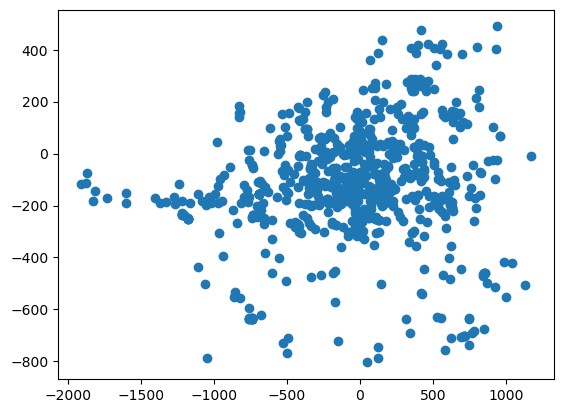

In [33]:
plt.scatter(df_test['room_coor_x'], df_test['room_coor_y'])

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 0, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,

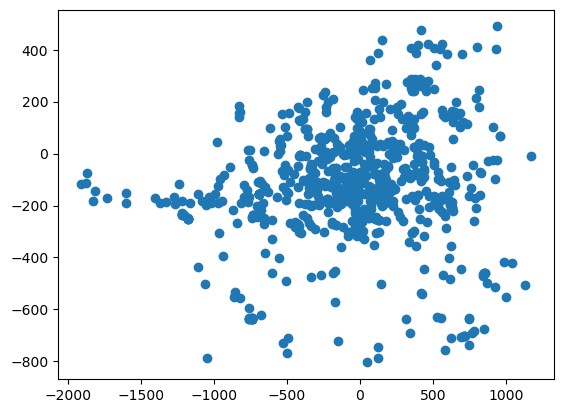

In [46]:
from sklearn.cluster import KMeans
df_test['room_coor_x_filled'] = df_test['room_coor_x'].fillna(df_test['room_coor_x'].mean())
df_test['room_coor_y_filled'] = df_test['room_coor_y'].fillna(df_test['room_coor_y'].mean())

plt.scatter(df_test['room_coor_x_filled'], df_test['room_coor_y_filled'])
X_train_lat_long = df_test[['room_coor_x_filled', 'room_coor_y_filled']].to_numpy()
kmeans = KMeans(n_clusters=3).fit(X_train_lat_long)
kmeans.labels_

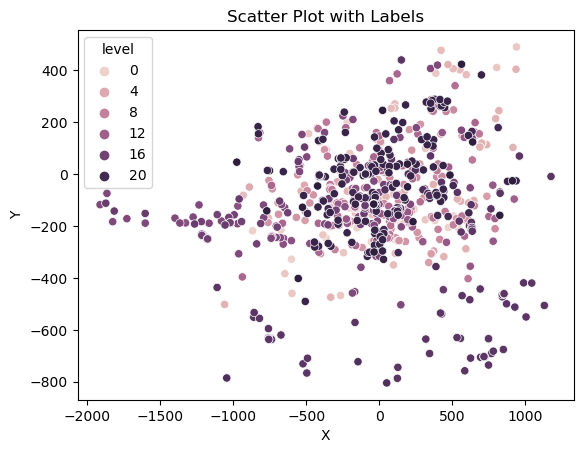

In [51]:
import seaborn as sns


# Create the scatter plot with labels
sns.scatterplot(x=df_test['room_coor_x_filled'], y=df_test['room_coor_y_filled'], hue=df_test['level'])

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Labels')

# Show the plot
plt.show()





In [47]:
import plotly.express as px

px.scatter(x=df_test['room_coor_x_filled'], y=df_test['room_coor_y_filled'], color=kmeans.labels_)

In [32]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
room_coor_x = df_test['room_coor_x']

# Standardize the data
#scaler = StandardScaler()
#room_coor_x_scaled = scaler.fit_transform(room_coor_x)

# Determine the optimal number of clusters (k)
# Perform elbow method or silhouette analysis

k = 5  # Example: Assuming the optimal number of clusters is 5

# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(room_coor_x)

# Obtain cluster labels
cluster_labels = kmeans.labels_


AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
plt.figure(figsize=(8, 4))

plt.hist(train['room_coor_x'], bins=50, alpha=0.5, label='room_coor_x')
plt.hist(train['room_coor_y'], bins=50, alpha=0.5, label='room_coor_y')
plt.hist(train['screen_coor_x'], bins=50, alpha=0.5, label='screen_coor_x')
plt.hist(train['screen_coor_y'], bins=50, alpha=0.5, label='screen_coor_y')
plt.xlabel('roomCo')
plt.ylabel('Frequency')
plt.title('Distribution of room and screen co-ordinate')
plt.legend()
plt.show()

<AxesSubplot:>

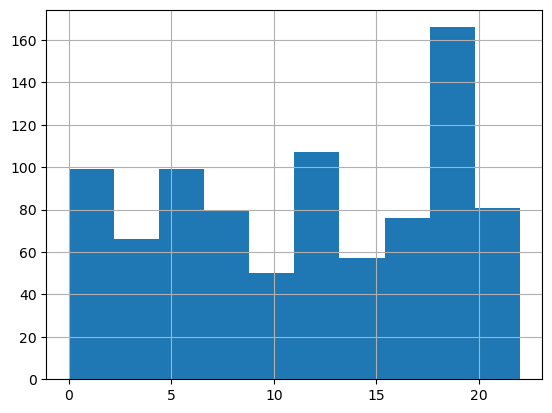

In [39]:
df_test= train[train["session_id"]==20090312431273200]
#df.x.plot
df_test.level.hist()

<AxesSubplot:>

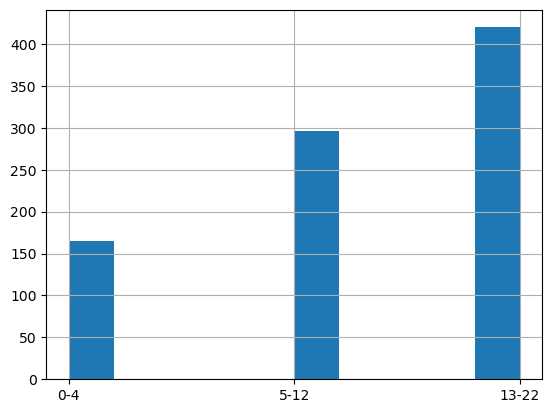

In [40]:
df_test= train[train["session_id"]==20090312431273200]
#df.x.plot
df_test.level_group.hist()

In [42]:
df_test= train[train["session_id"]==20090312431273200]
#df.x.plot
df_test.index.hist()

AttributeError: 'Int64Index' object has no attribute 'hist'

<AxesSubplot:>

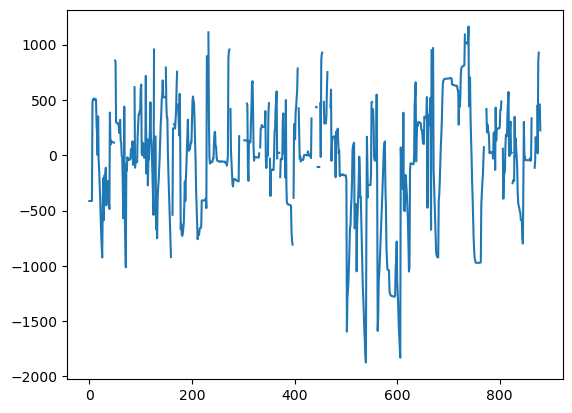

In [23]:
df_test= train[train["session_id"]==20090312431273200]
#df.x.plot
df_test.room_coor_x.plot()
#df_test.room_coor_y.plot()
#df_test.screen_coor_x.plot()
#df_test.screen_coor_y.plot()

In [58]:
len(df_test.room_coor_x.dropna())

813

In [68]:
data = pd.Series([1, 2, 3, 4, 5])
fft_result = np.fft.fft(df_test.room_coor_x.dropna())
#fft_result = np.fft.fft(data)
fft_mag = np.abs(fft_result)
#fft_mag_sorted = fft_mag[np.argsort(fft_mag)]
fft_mag_sorted = fft_mag[np.argsort(fft_mag)[::-1]]

In [55]:
uni = np.unique(fft_mag_sorted)
#uni_sort = uni[np.argsort(uni)[::-1]]

In [60]:
#uni

array([  106.82545018,   106.82545018,   339.97984864,   339.97984864,
         567.91785122,   567.91785122,   672.13880559,   672.13880559,
         857.85058336,   857.85058336,   897.44148335,   897.44148335,
        1053.6322989 ,  1053.6322989 ,  1066.26149483,  1066.26149483,
        1066.65396567,  1066.65396567,  1136.03097638,  1136.03097638,
        1226.70186578,  1226.70186578,  1297.05456424,  1297.05456424,
        1309.69217342,  1309.69217342,  1321.11344446,  1321.11344446,
        1327.37401834,  1327.37401834,  1367.57770859,  1367.57770859,
        1398.89576228,  1398.89576228,  1442.17553888,  1442.17553888,
        1445.77140231,  1445.77140231,  1452.94401873,  1452.94401873,
        1501.22628744,  1501.22628744,  1518.90876333,  1518.90876333,
        1521.41886504,  1521.41886504,  1562.8104054 ,  1562.8104054 ,
        1606.35683748,  1606.35683748,  1647.51313048,  1647.51313048,
        1689.96645764,  1689.96645764,  1701.92097337,  1701.92097337,
      

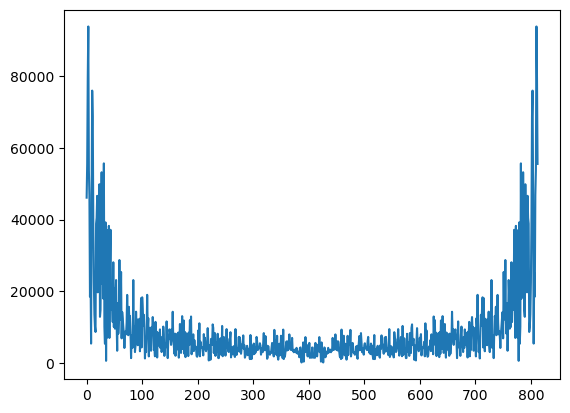

In [32]:
plt.plot(np.abs(fft_result))
plt.show()

In [69]:
freq = np.fft.fftfreq(len(df_test.room_coor_x.dropna()))

# sort the frequency values in ascending order
#freq_sorted = freq[np.argsort(freq)[::-1]]
#freq

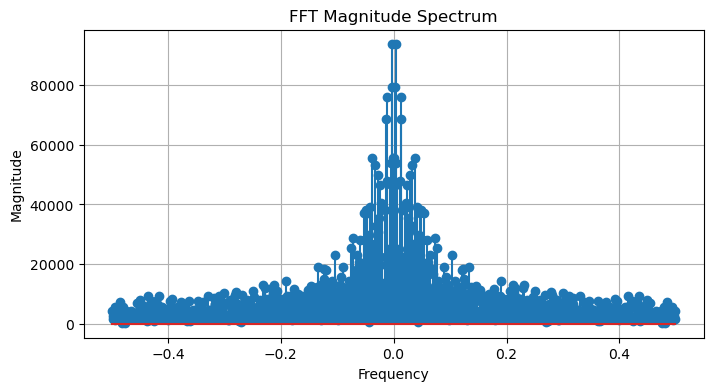

In [70]:
# Plot the magnitude spectrum
plt.figure(figsize=(8, 4))
plt.stem(freq, np.abs(fft_result))
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('FFT Magnitude Spectrum')
plt.grid(True)
plt.show()

<AxesSubplot:>

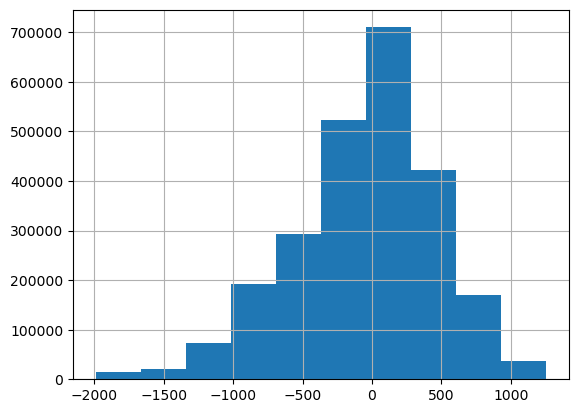

In [33]:
train.room_coor_x.hist()

In [ ]:
train.screen_coor_x.hist()

In [ ]:
train.screen_coor_y.hist()

In [ ]:
# min and max value
li=['room_coor_x','screen_coor_x','room_coor_y','screen_coor_y']
for i in li :
    print(i, "          min value :",round(train[i].min(),2), "   max value. :", round(train[i].max(),2), "   mean. :", round(train[i].mean(),2))    

In [ ]:
#print(train.isnull().sum() ,
train.isnull().sum()*100/len(train)

In [ ]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

In [ ]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text', 'text_fqid','name']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [ ]:
just coulmn name 

session_id         
index              

elapsed_time       

event_name        
name               
level              
page              
room_coor_x        
room_coor_y        
screen_coor_x      
screen_coor_y      
hover_duration    
text              
fqid              
room_fqid          
text_fqid         
fullscreen         
hq                 
music              
level_group        

In [ ]:
def listunique(list):
    for i in list:
        print("Unique value for", i , " is  :" , train[i].nunique())
        print( train[i].value_counts())
        print("------------------------------------")

In [ ]:
listunique(CATS)

In [ ]:
listunique(NUMS)

In [ ]:
for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')

In [ ]:
train.head()

In [ ]:
def feature_engineer(train):
    
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
        
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [ ]:
feature_engineer(train)

In [ ]:
%%time

# PROCESS TRAIN DATA IN PIECES
all_pieces = []
print(f'Processing train as {PIECES} pieces to avoid memory error... ')
for k in range(PIECES):
    print(k,', ',end='')
    SKIPS = 0
    if k>0: SKIPS = range(1,skips[k]+1)
    train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',
                        nrows=reads[k], skiprows=SKIPS)
    df = feature_engineer(train)
    all_pieces.append(df)
    
# CONCATENATE ALL PIECES
print('\n')
del train; gc.collect()
df = pd.concat(all_pieces, axis=0)
print('Shape of all train data after feature engineering:', df.shape )
df.head()

In [ ]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

In [ ]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

In [ ]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [ ]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

In [ ]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()



In [ ]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

In [ ]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

# CLEAR MEMORY
import gc
del targets, df, oof, true
_ = gc.collect()

In [ ]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    
    # FEATURE ENGINEER TEST DATA
    df = feature_engineer(test)
    
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[0,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int( p > best_threshold )
    
    env.predict(sample_submission)

In [ ]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

In [ ]:
print(df.correct.mean())